In [325]:
# import tsfresh

In [1]:
import numpy as np
import shap
n_features = 'all'
# data_file_name = 'data_for_training_tsfeatures_models'
data_file_name = 'data_for_traj_models'

endpt = 17
eval_times = np.r_[np.arange(1, endpt+1, 1)]
training_id_file_name = 'all_training_set_ID_2'
validation_id_file_name = 'all_validation_set_ID_2'
testing_id_file_name = 'all_testing_set_ID_2'
#work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project/'
work_dir = 'U:/Hieu/CARDIA_longi_project/'

In [327]:
# %pip install plotly
# %pip install tensorflow
# %pip install lifelines

#!y | pip uninstall statsmodels 
# %pip install statsmodels==0.11.0

# %pip install keras

In [2]:
import pkg_resources
#pkg_resources.require("scikit-learn==1.0.2")
import sklearn

import sksurv

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [3]:
load_dir = work_dir+ '/csv_files'

# load data:
data_full = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data_full = data_full.select_dtypes(include =[np.number])



In [4]:
# load training id:
loaddir = work_dir+ '/csv_files'
trainingid_all = pd.read_csv(loaddir+'/'+training_id_file_name+'.csv')
validationid_all = pd.read_csv(loaddir+'/'+validation_id_file_name+'.csv')
testingid_all = pd.read_csv(loaddir+'/'+testing_id_file_name+'.csv')


## no need to standardize feature space since RSF can handle it, then merge back to label space:
feature_space = data_full.drop(['ID','event','time'], axis = 1)
feature_name_list = feature_space.columns.values


In [5]:
data_full

,ID,event,time,MALE,RACEBLACK,ARMCI,ASMA,BEER,BMI,CANCR,...,GLU_cluster,HDL_cluster,LDL_cluster,NTRIG_cluster,PSTYR_cluster,PULSE_cluster,WGT_cluster,WST_cluster,DBP_cluster,SBP_cluster
0,100033323702,0,17.134155,1,0,35.0,0,0,25.680330,0,...,1,1,2,2,2,2,1,1,1,1
1,100056526386,0,17.142368,1,1,36.0,0,1,30.218171,0,...,1,1,2,2,2,2,1,1,2,2
2,100061300991,0,17.427105,1,1,35.0,0,8,30.062319,0,...,1,1,1,2,1,2,1,1,2,2
3,100080112533,0,17.057495,1,1,33.0,0,0,22.747420,0,...,1,1,1,2,1,1,1,1,2,2
4,100101126081,0,17.424367,0,1,50.0,0,0,39.548526,0,...,1,1,1,2,2,2,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534,416752023336,0,16.704312,1,1,33.0,0,0,26.210050,0,...,1,1,2,2,2,2,1,1,1,2
3535,416761219907,0,16.674196,0,0,29.0,0,0,25.692550,0,...,1,1,2,2,1,1,1,1,2,2
3536,416783315386,0,16.690623,0,0,25.5,0,0,20.409280,0,...,1,1,1,2,1,1,1,1,1,1
3537,416796224310,0,16.761807,0,1,41.5,1,0,40.326230,0,...,1,1,1,2,1,1,2,2,1,2


In [6]:
def f_rsf_input_as_matrix(X):
    surv = rsf.predict_survival_function(X, return_array=True)
    last_yr_pred_prob_surv=surv[:,-1]
    return last_yr_pred_prob_surv


def vimp_shap_tabular(feature_names, vals):
    feature_importance_df = pd.DataFrame(list(zip(feature_names, vals)), columns=['variable_name','vimp'])
    feature_importance_df.sort_values(by=['vimp'], ascending=False,inplace=True)
    feature_importance_df['normalized_vimp'] = (feature_importance_df['vimp'] - min(feature_importance_df['vimp']))/(max(feature_importance_df['vimp'])-min(feature_importance_df['vimp']))
    
   # merge with variable description:
   # var_dict = pd.read_csv(load_dir+'/y5_all_vars_dictionary_manually_selecting_vars (3).csv', encoding= 'unicode_escape')
   # var_dict[['Variable.Name', 'Variable.Label']]
    ## merge vimp table with var dict to get var description:
    # feature_importance_df_with_vardes = feature_importance_df.merge(
    #    var_dict[['Variable.Name', 'Variable.Label']], how = 'inner', right_on= 'Variable.Name', left_on = 'variable_name', copy= False)
    return(feature_importance_df[['variable_name','normalized_vimp','vimp']])


In [7]:
# Outerloop:
c_index = np.zeros((25,1))
# for fold in range(25):

## 
fold = 0
print('')
print('FOLD '+str(fold)+':')
print('')

# trainingid = trainingid_all.iloc[:,fold]
# trainingid = trainingid[~np.isnan(trainingid)]

trainingid = trainingid_all.iloc[:,fold].values
validationid = validationid_all.iloc[:,fold].values
testingid = testingid_all.iloc[:,fold].values

training_validation_id = np.concatenate([trainingid,validationid])
#training_validation_id = training_validation_id[~np.isnan(training_validation_id)]
#testingid = testingid[~np.isnan(testingid)]

#eligible_id = data_full['ID'][data_full['ID'].isin(training_validation_id)]
train_df = data_full.loc[data_full['ID'].isin(training_validation_id),:]
del train_df['ID']
test_df = data_full.loc[data_full['ID'].isin(testingid),:]
del test_df['ID']

featurespace_train_df = train_df.drop(['time','event'],axis =1)
featurespace_test_df = test_df.drop(['time','event'],axis =1)

featurespace_train = train_df.drop(['time','event'],axis =1).values
featurespace_test = test_df.drop(['time','event'],axis =1).values

y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)



FOLD 0:



In [8]:
featurespace_train_df

,MALE,RACEBLACK,ARMCI,ASMA,BEER,BMI,CANCR,CGTDY,CHOL,DFPAY,...,GLU_cluster,HDL_cluster,LDL_cluster,NTRIG_cluster,PSTYR_cluster,PULSE_cluster,WGT_cluster,WST_cluster,DBP_cluster,SBP_cluster
0,1,0,35.0,0,0,25.680330,0,0,214,4,...,1,1,2,2,2,2,1,1,1,1
2,1,1,35.0,0,8,30.062319,0,8,202,3,...,1,1,1,2,1,2,1,1,2,2
6,0,1,43.0,0,0,47.283535,0,0,151,4,...,1,1,1,2,2,1,2,1,1,1
8,0,1,31.0,0,0,27.715143,0,0,175,3,...,1,1,1,2,2,1,1,1,1,2
9,0,0,27.0,0,0,23.167743,0,0,209,4,...,1,1,1,2,1,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3533,1,1,33.0,0,10,26.405970,0,0,185,4,...,1,2,1,2,1,2,1,1,2,1
3535,0,0,29.0,0,0,25.692550,0,0,254,4,...,1,1,2,2,1,1,1,1,2,2
3536,0,0,25.5,0,0,20.409280,0,0,130,4,...,1,1,1,2,1,1,1,1,1,1
3537,0,1,41.5,1,0,40.326230,0,0,150,4,...,1,1,1,2,1,1,2,2,1,2


In [9]:
featurespace_test_df

,MALE,RACEBLACK,ARMCI,ASMA,BEER,BMI,CANCR,CGTDY,CHOL,DFPAY,...,GLU_cluster,HDL_cluster,LDL_cluster,NTRIG_cluster,PSTYR_cluster,PULSE_cluster,WGT_cluster,WST_cluster,DBP_cluster,SBP_cluster
1,1,1,36.0,0,1,30.218171,0,0,160,4,...,1,1,2,2,2,2,1,1,2,2
3,1,1,33.0,0,0,22.747420,0,0,161,4,...,1,1,1,2,1,1,1,1,2,2
4,0,1,50.0,0,0,39.548526,0,0,135,4,...,1,1,1,2,2,2,1,1,2,2
5,1,1,39.0,0,0,33.027582,0,0,206,4,...,1,1,2,2,2,2,2,2,2,2
7,0,0,27.0,0,0,22.466026,0,0,160,3,...,1,2,1,2,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,0,0,23.6,0,0,20.454460,0,0,161,4,...,1,1,1,2,2,2,1,1,1,1
3510,0,1,31.0,0,0,27.276500,0,20,104,4,...,1,1,1,2,2,1,1,2,1,2
3514,0,1,32.5,0,0,33.472680,0,0,199,4,...,1,1,1,2,2,2,2,2,1,2
3519,0,0,27.4,0,0,23.062200,0,0,122,4,...,1,1,1,2,2,2,1,1,1,1


In [10]:

##########################
# Build model:


seed(1)
rsf = RandomSurvivalForest(n_estimators=1001,
                       min_samples_split=10,
                       min_samples_leaf=15,
                       max_features="sqrt",
                       n_jobs=-1,
                       random_state=20)
rsf.fit(featurespace_train_df, y_train) 

rsf.score(featurespace_test_df, y_test) 
c_index[fold] = rsf.score(featurespace_test_df, y_test) 

savedir = os.path.join(work_dir,'csv_files/rsf_traj_SHAP/'+str(n_features)+'_features/')
try: 
    os.makedirs(savedir)
except OSError:
    if not os.path.isdir(savedir):
        raise
actual_fold = fold+1


## SHAP:

seed(1)
X_train_df_summary = shap.kmeans(featurespace_train_df, 10) #10

seed(1)
explainer_kmeans = shap.KernelExplainer(f_rsf_input_as_matrix, X_train_df_summary, feature_names=feature_name_list) 
kmeans_shaps = explainer_kmeans.shap_values(featurespace_test_df)



In [11]:
vimp_shap_kmeans = vimp_shap_tabular(feature_name_list, np.abs(kmeans_shaps).mean(0))

vimp_shap_kmeans.to_csv(savedir+'/shap_kernel_explainer_expanded_var_fold_'+str(actual_fold)+'.csv', index = None, header = True)


In [12]:
pd.DataFrame(kmeans_shaps).to_csv(savedir+'/all_kmeans_shap_values_expanded_var_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [14]:
savedir

'U:/Hieu/CARDIA_longi_project/csv_files/rsf_traj_SHAP/all_features/'

In [15]:
kmeans_shaps_df = pd.DataFrame(kmeans_shaps)
kmeans_shaps_df.columns = featurespace_test_df.columns
pd.DataFrame(kmeans_shaps_df).to_csv(savedir+'/all_kmeans_shap_values_df_expanded_var_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [ ]:
savedir

In [ ]:
old_loadir = 'U:/Hieu/CARDIA_longi_project/csv_files/rsf_tsfresh/all_features'
old_kmeans_shaps = pd.read_csv(old_loadir+'/all_kmeans_shap_values_fold_'+str(actual_fold)+'.csv')

In [ ]:
old_kmeans_shaps

In [ ]:
shap.initjs()
shap.summary_plot(old_kmeans_shaps, featurespace_test_df.iloc[:,:])


In [ ]:
explainer_kmeans

In [ ]:
explainer_kmeans.expected_value
# pd.DataFrame(explainer_kmeans.expected_value).to_csv(savedir+'/explainer_kmeans_expected_values_fold_'+str(actual_fold)+'.csv', index = None, header = True)
with open(savedir+'/explainer_kmeans_expected_values_2_fold_'+str(actual_fold)+'.txt', 'w') as f:
    f.write(str(explainer_kmeans.expected_value))


In [ ]:
# import pickle 
# file_explainer_kmeans = open(savedir+'/'+'file_explainer_kmeans.obj', 'wb') 
# pickle.dump(explainer_kmeans, file_explainer_kmeans)



In [ ]:
# import pickle 

# load_kmeans_shaps = pickle.load(open(savedir+'/'+'file_kmeans_shaps.obj', 'r'))

In [ ]:
kmeans_shaps.shape

In [ ]:
explainer_kmeans.expected_value

In [ ]:
shap.initjs()
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[0],featurespace_test_df.iloc[0,:])


In [ ]:
kmeans_shaps.shape

In [ ]:
featurespace_test_df.shape

In [ ]:
featurespace_test_df['GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.6'].corr(featurespace_test_df['GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.0'])


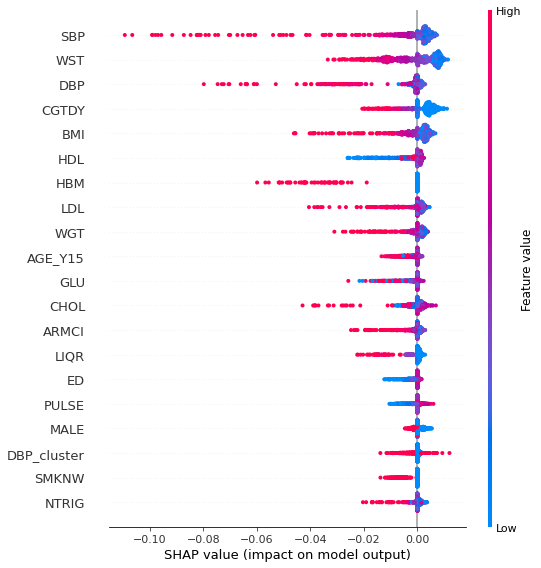

In [16]:
shap.initjs()
shap.summary_plot(kmeans_shaps, featurespace_test_df.iloc[:,:])


In [ ]:
shap.initjs()

idx_glu = featurespace_test_df.columns.get_loc('GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.6')
kmeans_shaps_wo_var_oi = np.delete(kmeans_shaps, idx_glu, 1)
featurespace_test_df_wo_var_oi = featurespace_test_df.drop(featurespace_test_df.columns[idx_glu], axis=1)
shap.summary_plot(kmeans_shaps_wo_var_oi, featurespace_test_df_wo_var_oi)


In [ ]:
shap.summary_plot(kmeans_shaps_wo_var_oi, featurespace_test_df_wo_var_oi, plot_type = 'bar')


In [ ]:
# shap.initjs()

shap.summary_plot(kmeans_shaps, featurespace_test_df.iloc[:,:], plot_type = 'bar')


In [ ]:
# old:
vimp_shap_kmeans.variable_name[:20].values

In [ ]:
# new:
vimp_shap_kmeans.variable_name[:30].values

In [ ]:
shap.dependence_plot("HDL__linear_trend__attr_.intercept.", kmeans_shaps, featurespace_test_df) #,interaction_index=None)


In [ ]:
# shap.dependence_plot("SBP__standard_deviation", kmeans_shaps, featurespace_test_df,interaction_index=None)


In [ ]:
# # old:
# top_n_var = 20
# top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
# for i in range(top_n_var):
#     var_oi = top_var_names_arr[i]
#     shap.dependence_plot(var_oi, kmeans_shaps, featurespace_test_df,interaction_index=None)



In [ ]:
# import matplotlib.pyplot as plt
# kmeans_shaps[:,idx_glu].shape
# featurespace_test_df.iloc[:, idx_glu].shape
# plt.scatter(featurespace_test_df.iloc[:, idx_glu], kmeans_shaps[:,idx_glu])

In [ ]:
test_df

In [ ]:
df_for_bc.loc[df_for_bc[featurespace_test_df.columns[idx_oi]] > 5000]

In [ ]:
data_full.loc[data_full['ID'].isin(testingid),:].loc[featurespace_test_df['GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.6'] > 5000]

In [ ]:

# import plotly.graph_objects as go

# fig_scatter = px.scatter(df_for_bc
#     , x= featurespace_test_df.columns[idx_oi]
#     , y='SHAP value'
#     , size='time'
#     , color='event'
#                  #hover_name="country"
#                  #, log_x=True,                               
#                  , size_max=10
                
#                 )

# fig = go.Figure(data=[go.Scatter(
#     df_for_bc.to_dict()
#     , x= featurespace_test_df.columns[idx_oi]
#     , y='SHAP value'
#     , size='time'
#     , color='event'
    
#     , mode='markers',
#     marker=dict(
#         color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',
#                'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
#         opacity=[1, 0.8, 0.6, 0.4],
#         size=[40, 60, 80, 100],
#     )
# )])

# fig.show()


# fig.show()

In [ ]:
## Bubble Chart:


idx_SBP = featurespace_test_df.columns.get_loc('SBP')


idx_oi = idx_SBP
df_for_bc = pd.DataFrame({featurespace_test_df.columns[idx_oi]:featurespace_test_df.iloc[:, idx_oi]
                         , 'SHAP value': kmeans_shaps[:,idx_oi]
                         , 'event': test_df.event.values
                         , 'time': test_df.time.values})
df_for_bc['Event'] = df_for_bc['event'].astype('category')

# df_for_bc['invert_time'] = swap_relative_values(df_for_bc['time'])
df_for_bc['invert_time'] = -(df_for_bc['time'])
df_for_bc['Time (months)'] = -(df_for_bc['time'])


import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
#sns.set()
#fig, ax = plt.subplots(figsize=(10, 10))

bc_plot = sns.scatterplot(data=df_for_bc
                , x=featurespace_test_df.columns[idx_oi]
                , y='SHAP value'
                , size= 'Time (months)'
                , hue='Event', palette = ['dodgerblue', 'crimson']
                , alpha=0.4, sizes=(40, 800)
                # , ax = ax
                , legend = False
                )
# plt.legend(loc = 'center left', markerscale = 2
#            , bbox_to_anchor = (1, 0.5))

plt.show()



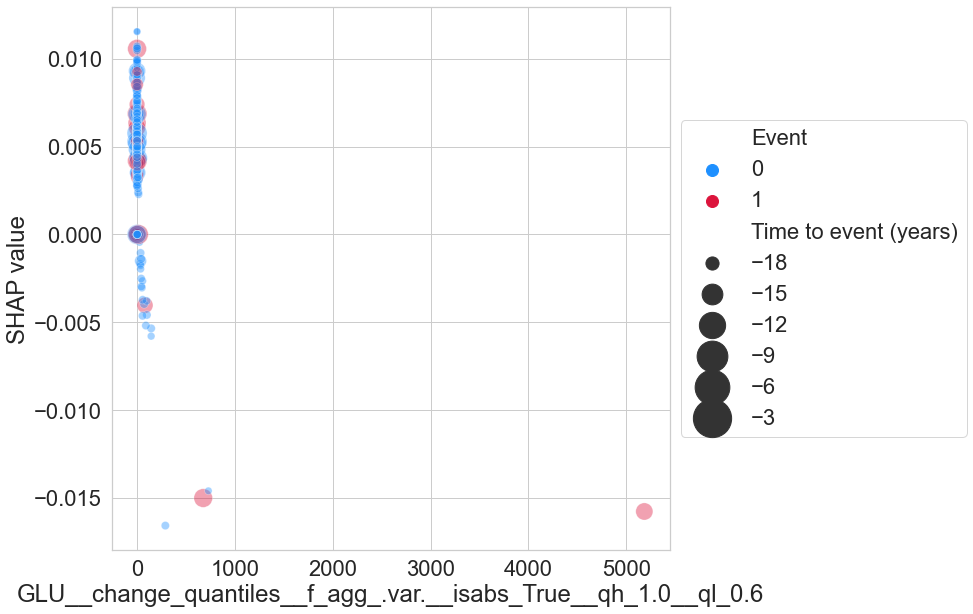

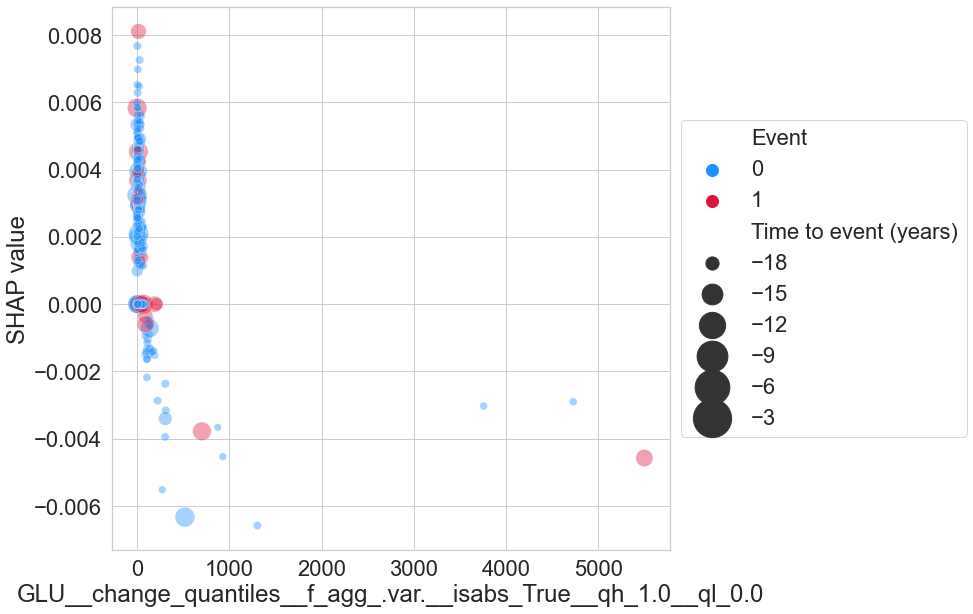

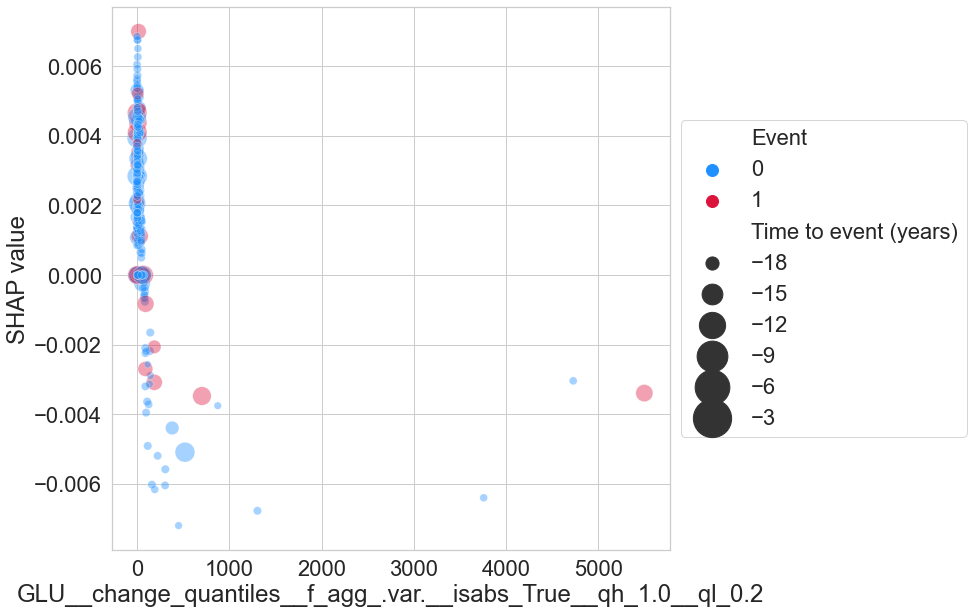

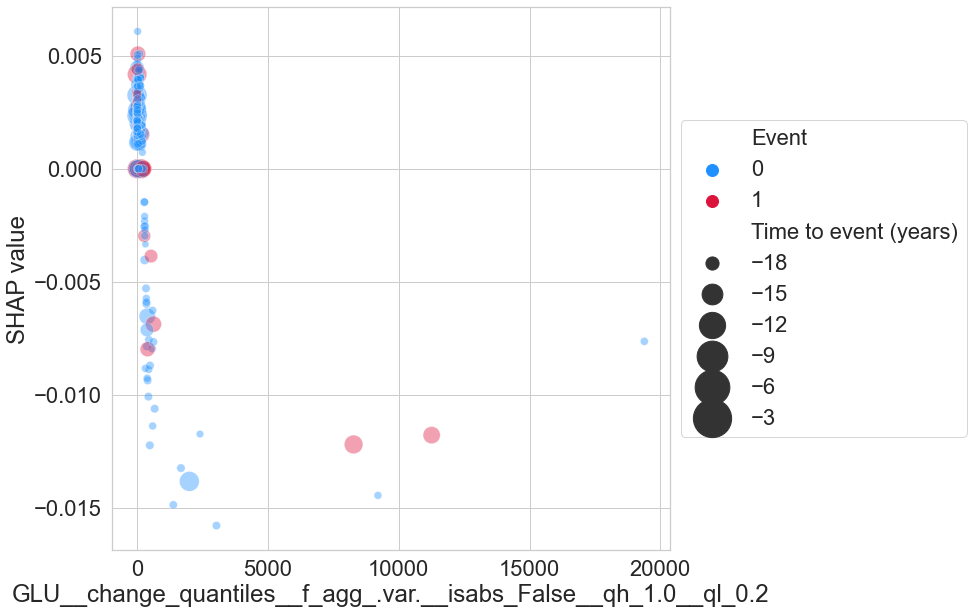

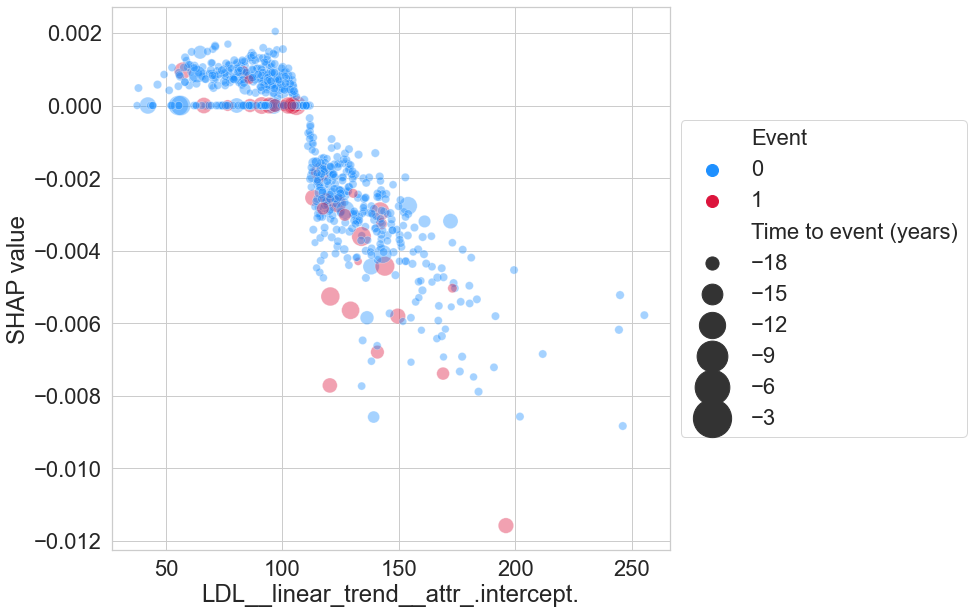

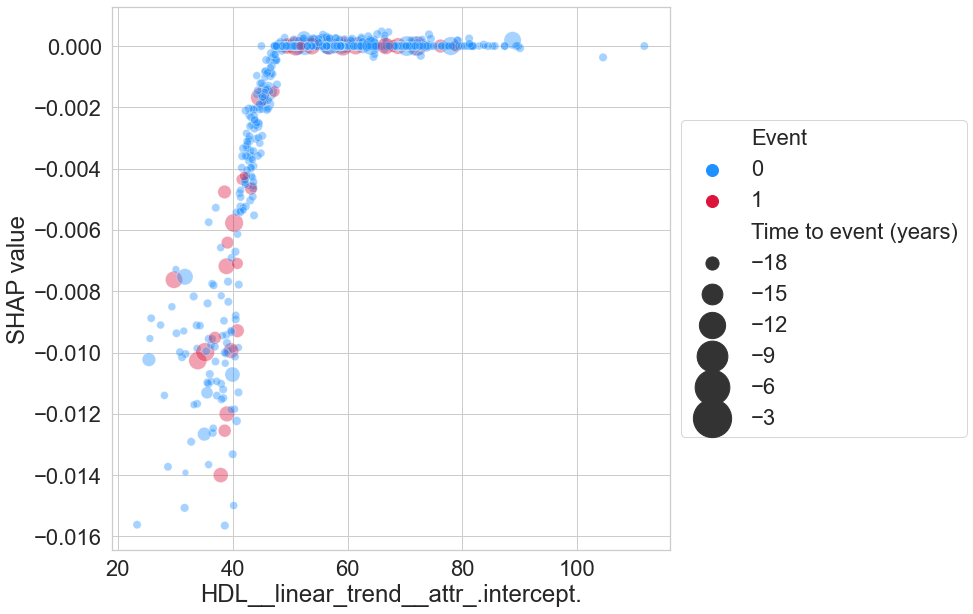

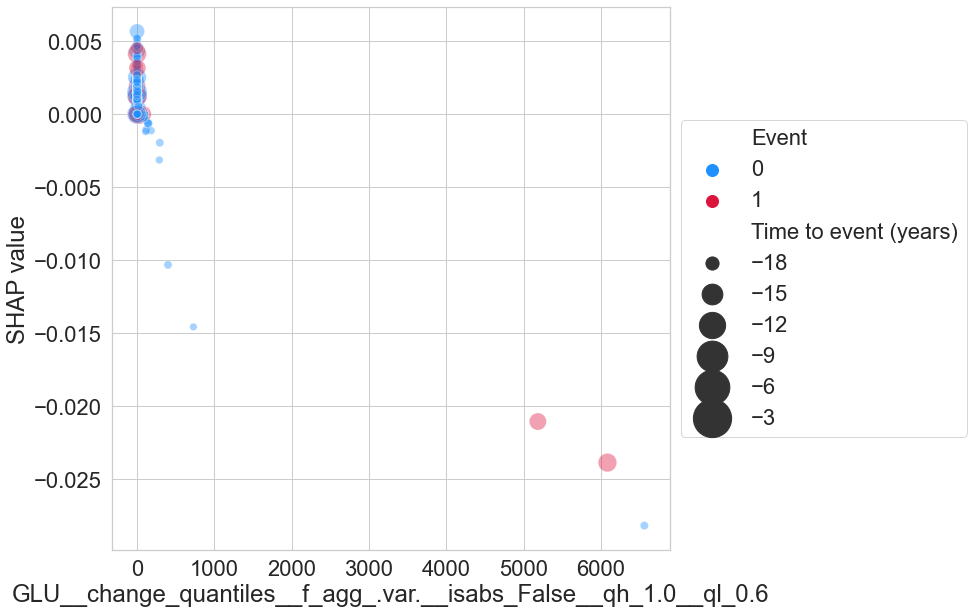

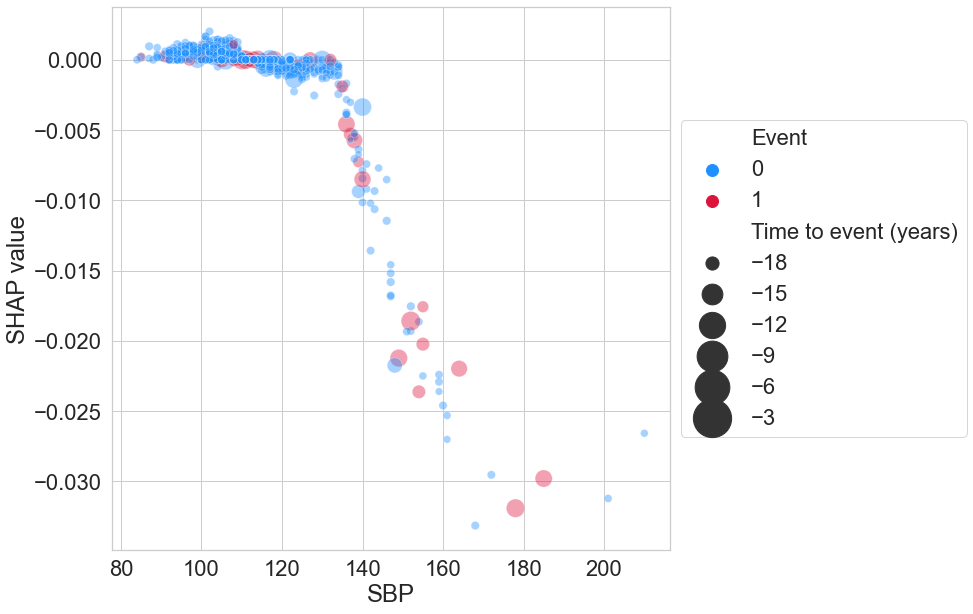

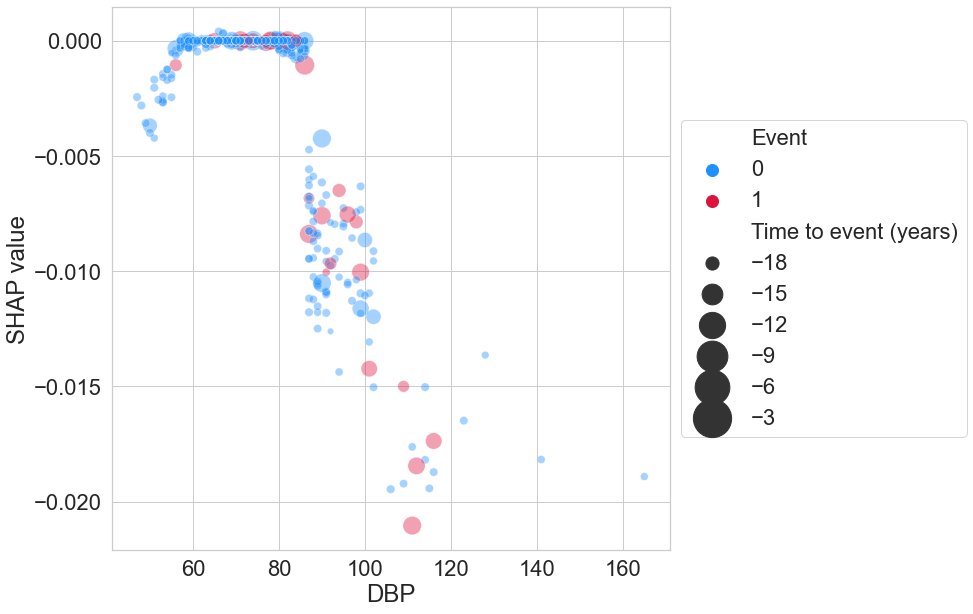

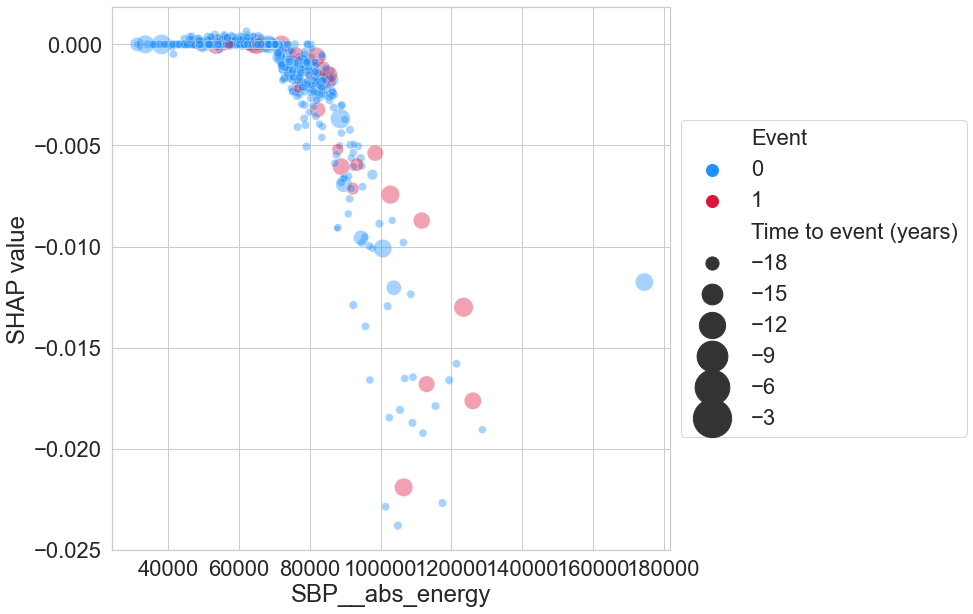

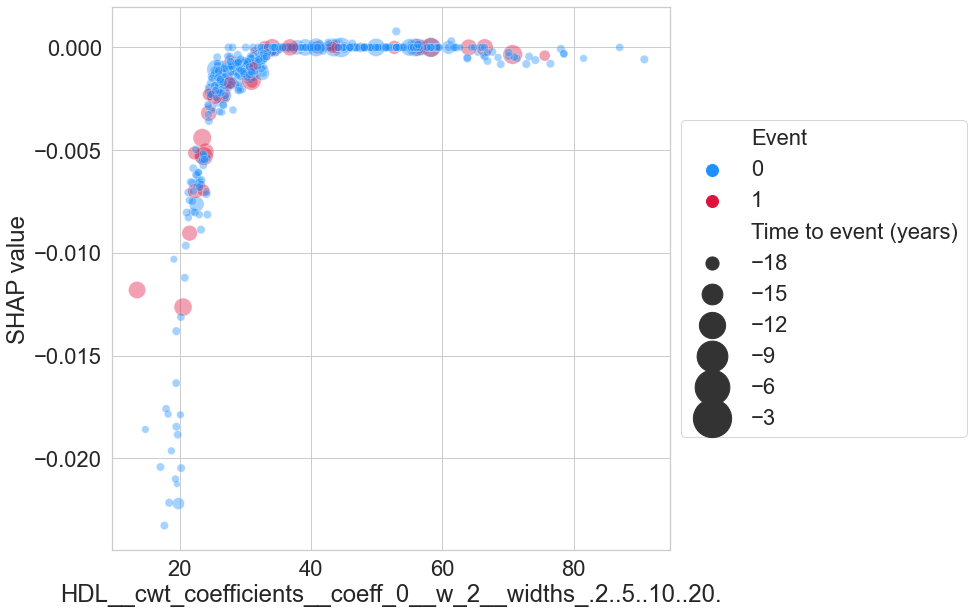

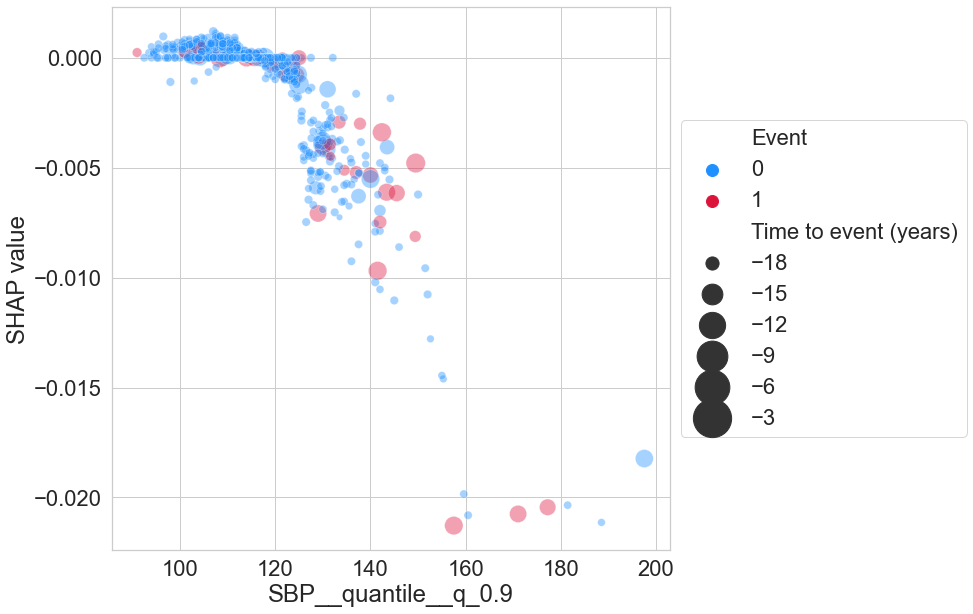

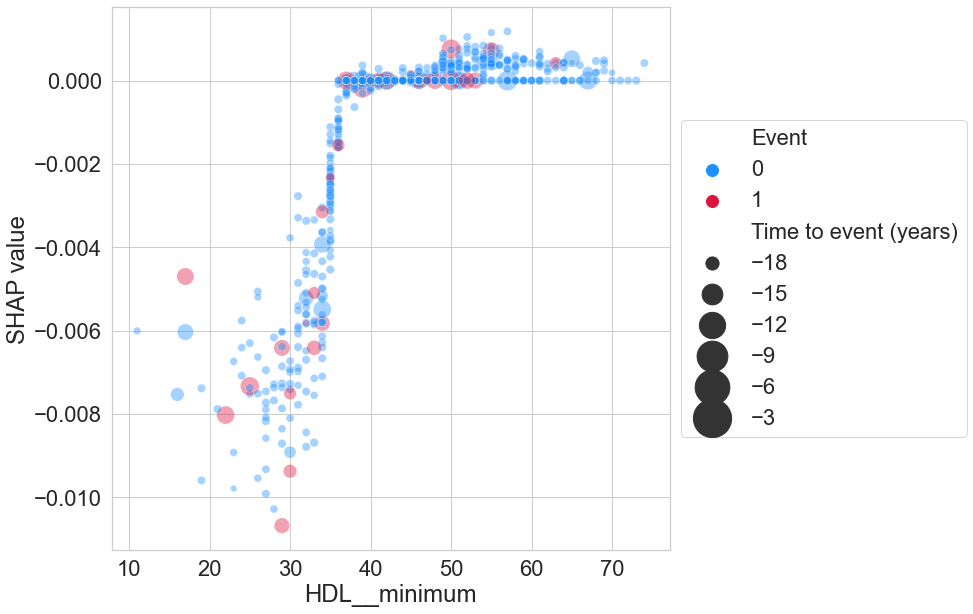

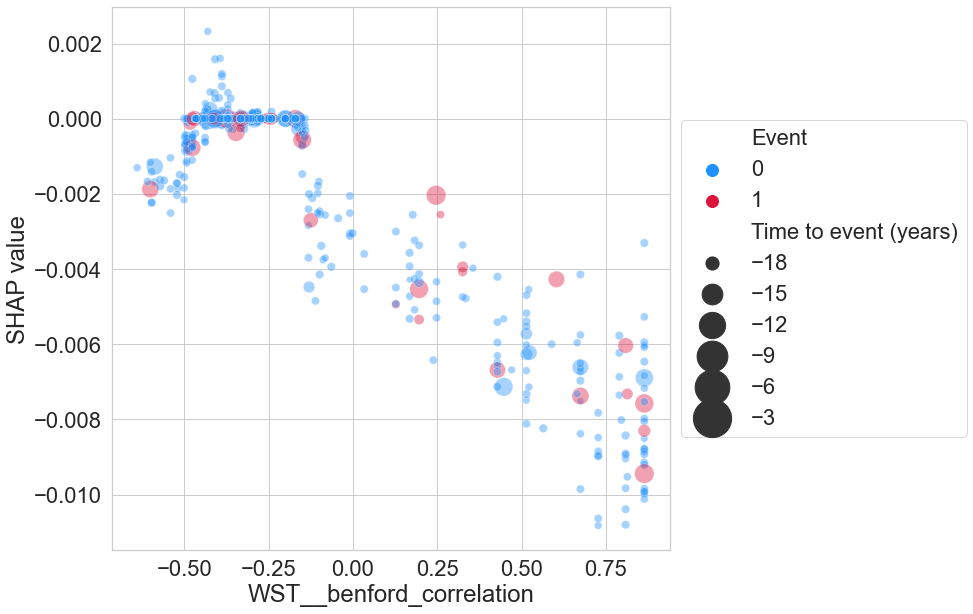

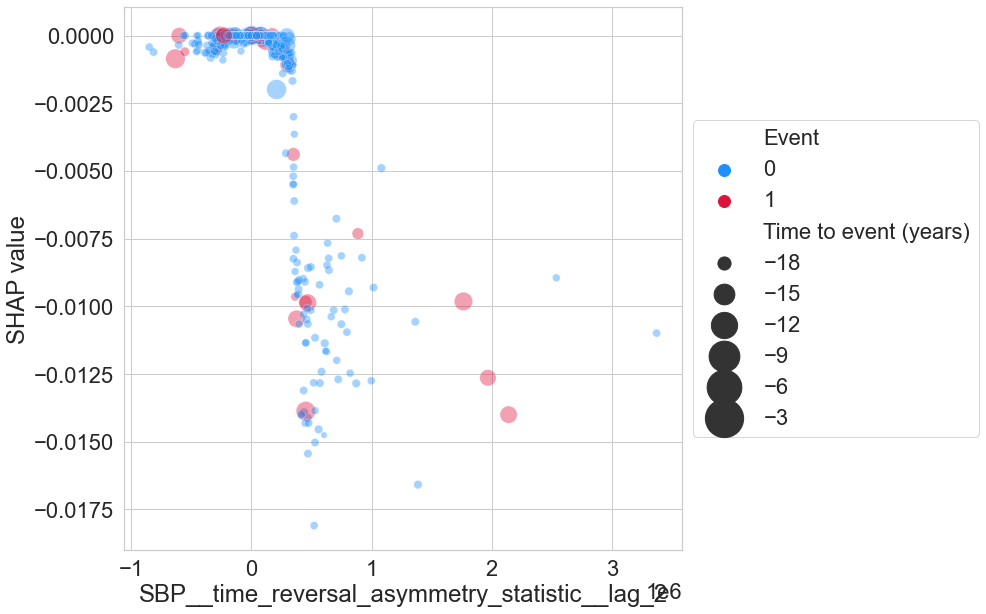

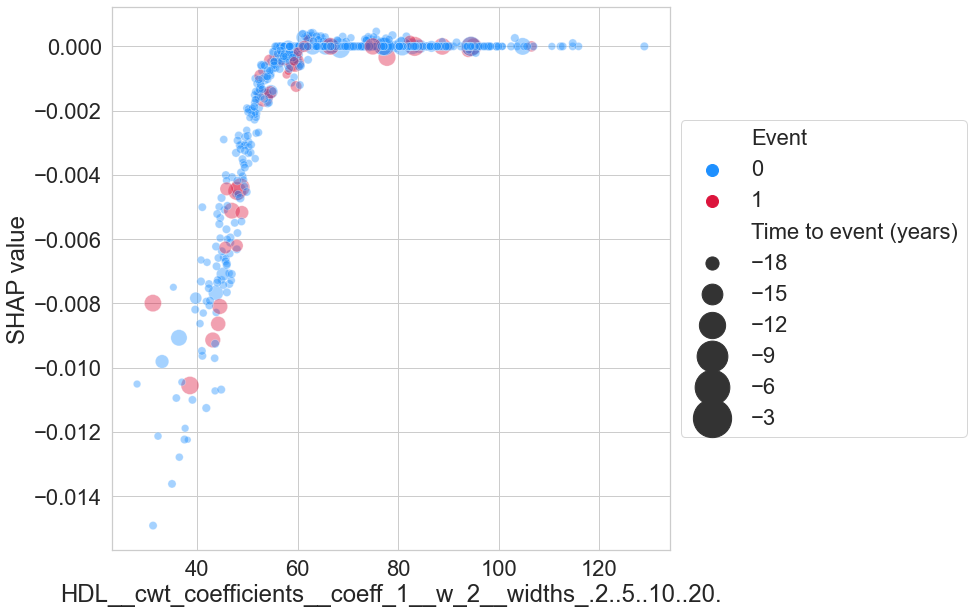

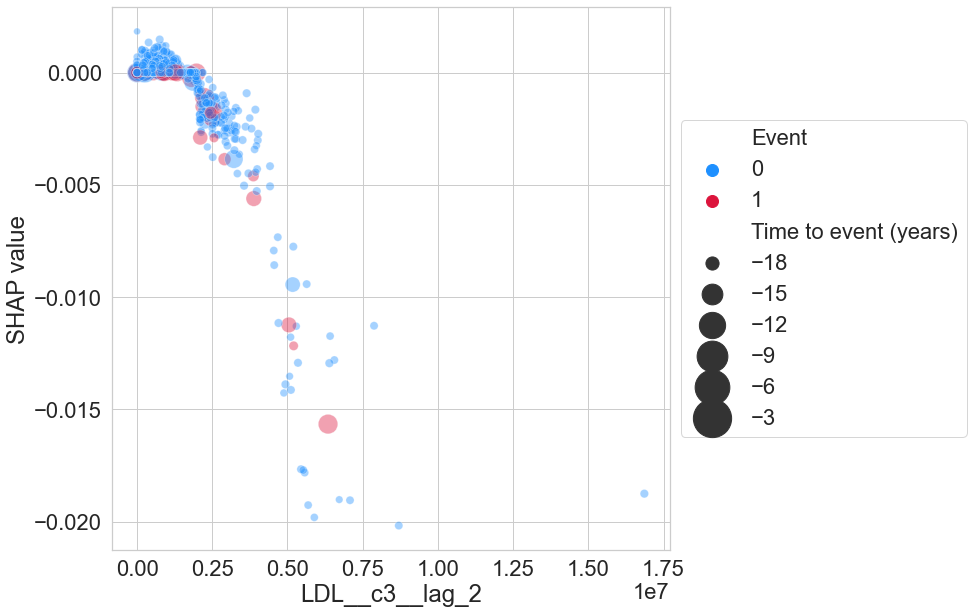

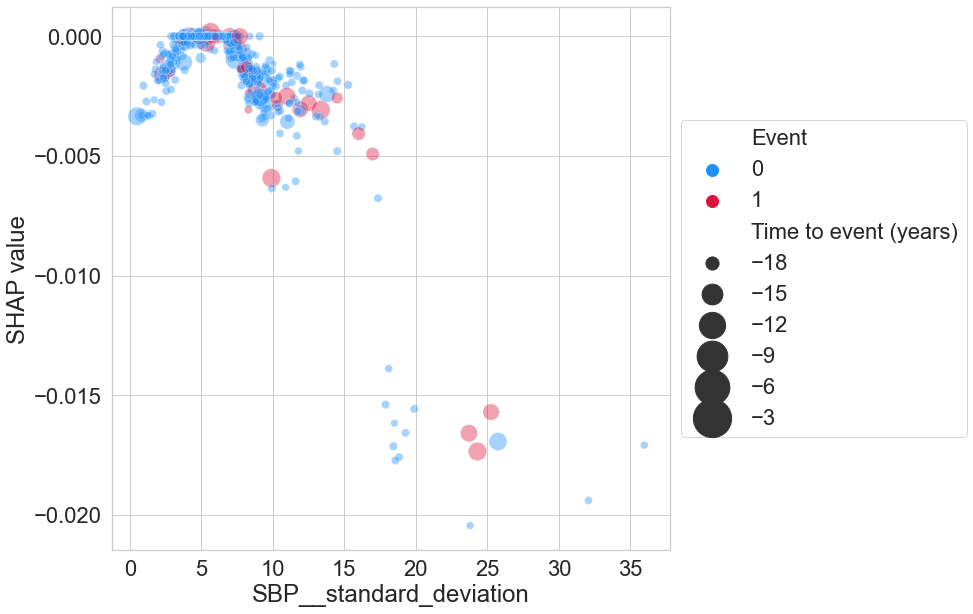

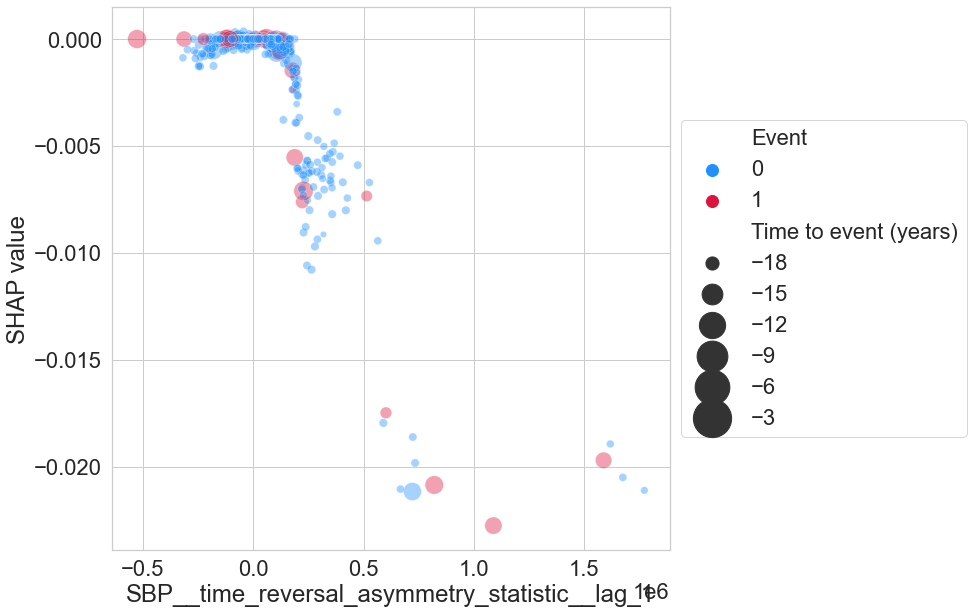

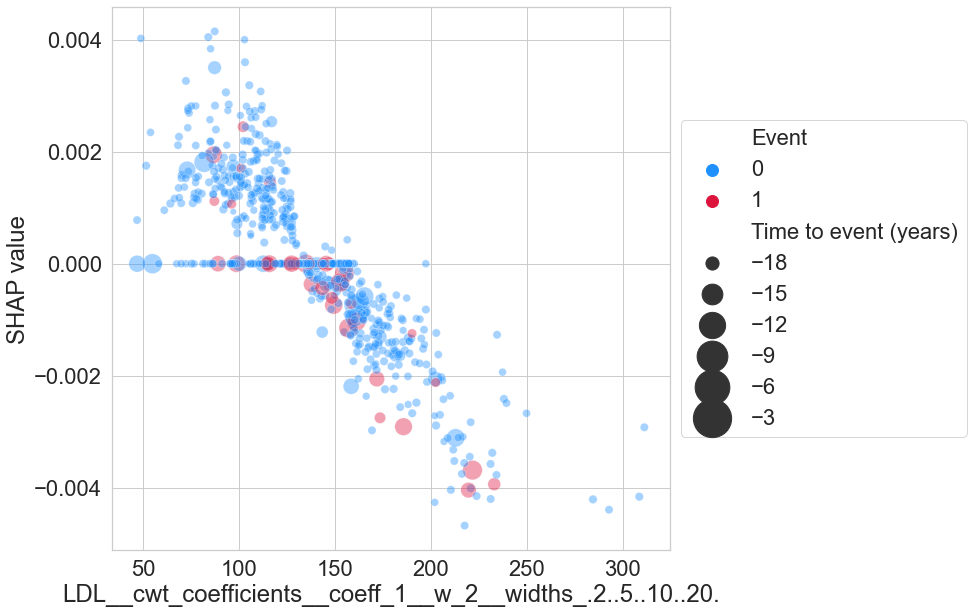

In [337]:
## Bubble Chart:

def plot_bubble_chart_SHAP(df, var):

    idx_oi = df.columns.get_loc(var)
    df_for_bc = pd.DataFrame({df.columns[idx_oi]:df.iloc[:, idx_oi]
                             , 'SHAP value': kmeans_shaps[:,idx_oi]
                             , 'event': test_df.event.values
                             , 'time': test_df.time.values})
    df_for_bc['Event'] = df_for_bc['event'].astype('category')

    df_for_bc['invert_time'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])


    import seaborn as sns
    sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
    #sns.set()
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    bc_plot = sns.scatterplot(data=df_for_bc
                    , x=df.columns[idx_oi]
                    , y='SHAP value'
                    , size= 'Time to event (years)'
                    , hue='Event', palette = ['dodgerblue', 'crimson']
                    , alpha=0.4, sizes=(40, 400)
                    # , ax = ax
                    #, legend = False
                    # , label = str(Time_in_years) + ' years'
                    )
    plt.legend(loc = 'center left', markerscale = 2
               , bbox_to_anchor = (1, 0.5))

    plt.show()


top_n_var = 20
top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
for i in range(top_n_var):
    plot_bubble_chart_SHAP(featurespace_test_df, top_var_names_arr[i])
    

In [ ]:
# top_n_var = 20
# top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
# for i in range(top_n_var):
#     var_oi = top_var_names_arr[i]
#     shap.dependence_plot(var_oi, kmeans_shaps, featurespace_test_df,interaction_index=None)

